# Calculating temporal variance with and without seasonal cycle

In [18]:
using CABLAB
using CABLAB.Mask

   A Cube is defined via its path and some a single variable is read into memory. // some a  single ???

In [19]:
c             = Cube("/Net/Groups/BGI/scratch/DataCube/v0.2.0/high-res")

CABLAB data cube at /Net/Groups/BGI/scratch/DataCube/v0.2.0/high-res
Spatial resolution:  4320x2160 at 0.083333 degrees.
Temporal resolution: 2001-01-01T00:00:00 to 2012-01-01T00:00:00 at 8daily time steps
Variables:           aerosol_optical_thickness_1610 aerosol_optical_thickness_550 aerosol_optical_thickness_555 aerosol_optical_thickness_659 aerosol_optical_thickness_865 air_temperature_2m bare_soil_evaporation black_sky_albedo burnt_area c_emissions country_mask evaporation evaporative_stress fractional_snow_cover gross_primary_productivity interception_loss land_surface_temperature latent_energy net_ecosystem_exchange open_water_evaporation ozone potential_evaporation precipitation root_moisture sensible_heat snow_sublimation snow_water_equivalent soil_moisture surface_moisture terrestrial_ecosystem_respiration transpiration water_mask water_vapour white_sky_albedo 


    Bio: burnt_area, evaporation, evaporative_stress,gross_primary_productivity, interception_loss, land_surface_temperature, latent_energy, net_ecosystem_exchange,surface_moisture, terrestrial_ecosystem_respiration, transpiration
    Atmo: aerosol_optical_thickness_550,air_temperature_2m, black_sky_albedo,ozone,potential_evaporation, precipitation,water_vapour,white_sky_albedo 

In [20]:
cdata         = getCubeData(c,variable="soil_moisture",latitude=(35,65), longitude=(-15,40));

Here we demonstrate how to add a user-defined function to use the DAT's capabilities. First we define the function that has the signature *xin* (input data), *xout* (output data), *maskin* (input mask), *maskout* (output mask). In this case it simply cacluates the variance of a time series. Then we call registerDATFunction, makes the function simply callable thourgh mapCube. 

In [21]:
function varianceTime{T}(xout::AbstractArray{T,0},maskout::AbstractArray{UInt8,0},xin::AbstractVector{T},maskin::AbstractVector)
  s=0.0
  s2=0.0
  n=0
  for i in eachindex(xin)
    if maskin[i]==VALID
      s+=xin[i]
      s2+=xin[i]*xin[i]
      n+=1
    end
  end
  if n>0
    xout[1]=s2/n-(s/n)*(s/n)
    maskout[1]=VALID
  else
    maskout[1]=MISSING
  end
end

CABLAB.DAT.registerDATFunction(varianceTime,(TimeAxis,),());

Here we call the function with our 3D data cube as its argument.

In [22]:
v1             = mapCube(varianceTime,cdata);
cube_anomalies = mapCube(removeMSC,cdata);
v2             = mapCube(varianceTime,cube_anomalies);

We get the spatial mean of the time variances

And show the maps of variances:

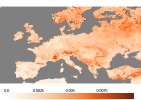

In [32]:
plotMAP(v1,dmin=0.0f0,dmax=0.01f0)
plotMAP(v2,dmin=0.0f0,dmax=0.01f0)

**Comments: Output is only one plot. I expected two.**

In [26]:
mv1=mapCube(spatialMean,(v1,v1.axes[2]))
mv2=mapCube(spatialMean,(v2,v2.axes[2]))
println("Mean variance with seasonal cycle: ", mv1.data[1])
println("Mean variance without seasonal cycle: ", mv2.data[1])

LoadError: LoadError: UndefVarError: spatialMean not defined
while loading In[26], in expression starting on line 1

**Comments: Error: the function spatialMean is not defined.**

In [ ]:
run()